In [1]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from mcmc import *
import pickle

## Wczytanie danych

In [2]:
with open("./data/corpus_wikipedia_2020-03-01_all_lines.txt") as f:
    lines = f.readlines(int(1e8))


In [3]:
full_text = " ".join(lines).lower().replace('!', '.')


In [4]:
len(full_text)


100888469

In [5]:
known_chars = "aąbcćdeęfghijklłmnńoóprsśtuvwxyzżź0123456789 ,."


In [6]:
full_text = remove_unknown_symbols(known_chars, full_text)

In [7]:
text_to_decode = (
    "na fundamentach starego urzędu gminy, rozpoczęto budowę nowego obiektu, mającego w przyszłości spełniać rolę gminnego ośrodka kultury gok."
    " uroczyście otwarty w dniu 23 maja 1989 r. gminny ośrodek kultury, zwany z racji widniejącego na frontonie rzeźby mitycznego pegaza,"
    " pod pegazem, okazał się wyśmienitym obiektem do pełnienia roli do jakiej został powołany."
).lower()

## Sprawdzenie wpływu długości tekstu wejściowego na stabilność dekodowania

In [59]:
text_lengths = [10**i for i in range(4,8)] +[len(full_text)]

In [60]:
text_lengths

[10000, 100000, 1000000, 10000000, 98777608]

In [86]:
random.seed(123)
hamming_losses_arrays = []
final_texts = []
runs_scores = []
iters = int(1e+5)
num_repeats = 30
num_previous_chars=1
for text_length in text_lengths:
    count_dict = create_count_dict(full_text[:text_length], known_chars)
    perc_dict = create_perc_dict(count_dict, known_chars)

    crypt_keys = create_rand_crypt(known_chars)
    crypt_dict = str_to_key(known_chars, crypt_keys)
    crypt_text = apply_dict(text_to_decode, crypt_dict)
    

    _final_texts = []
    run_scores = []
    hamming_losses_array = []
    for _ in range(num_repeats):
        current_dict, scores, best_text, hamming_losses = decrypt_MCMC(crypt_text, perc_dict, crypt_keys, known_chars, iters,verbose = False, real_text=text_to_decode, num_previous_chars=num_previous_chars)
        hamming_losses_array.append(hamming_losses)
        _final_texts.append(best_text[-1])
        run_scores.append(np.array(scores))
    hamming_losses_array = np.array(hamming_losses_array)
    final_texts.append(_final_texts)
    hamming_losses_arrays.append(hamming_losses_array)
    runs_scores.append(np.stack(run_scores))

hamming_losses_arrays = np.stack(hamming_losses_arrays)
runs_scores = np.stack(runs_scores)

100%|██████████| 1966/1966 [00:00<00:00, 1352912.50it/s]


In [94]:
with open('evaluations/text_length_tests/final_texts.pkl', 'wb') as f:
    pickle.dump(final_texts, f)

np.save('./evaluations/text_length_tests/hamming_losses.npy', hamming_losses_arrays)
np.save('./evaluations/text_length_tests/scores.npy', runs_scores)

In [99]:
for hamming_losses_array in hamming_losses_arrays:
    print(np.mean(hamming_losses_array[:,-1]))

0.9746296296296297
0.6514814814814814
0.6650925925925928
0.3566666666666667
0.2753703703703704


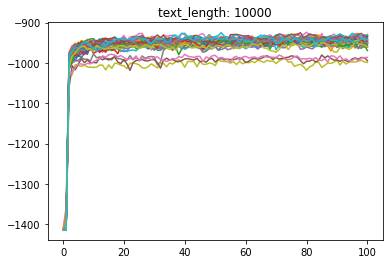

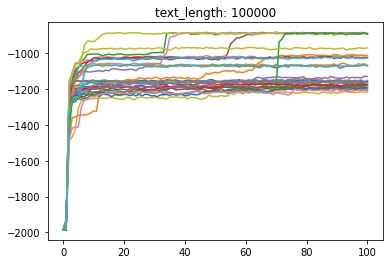

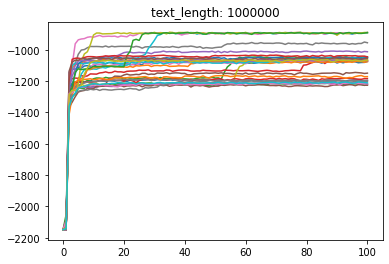

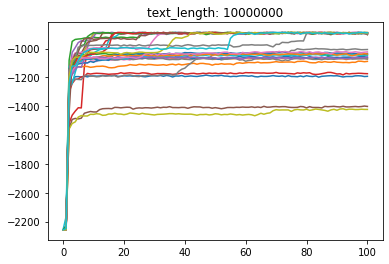

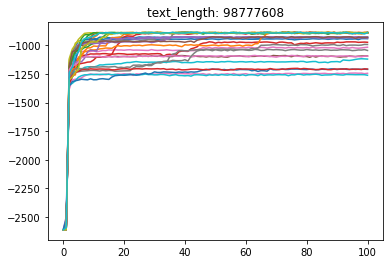

In [89]:
run_num = 0
for run_num in range(len(runs_scores)):
    for i in range(runs_scores[run_num].shape[0]):
        plt.plot(runs_scores[run_num][i])
    plt.title(f'text_length: {text_lengths[run_num]}')
    plt.show()


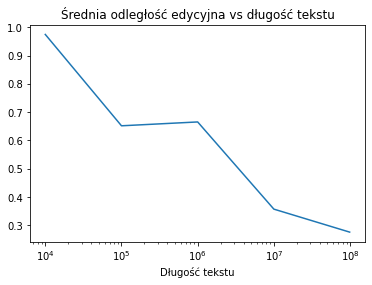

In [100]:
ax = plt.plot(text_lengths, [np.mean(hamming_losses_array[:,-1]) for hamming_losses_array in hamming_losses_arrays])
plt.title('Średnia odległość edycyjna vs długość tekstu')
plt.xscale('log')
plt.xlabel('Długość tekstu')
plt.show()

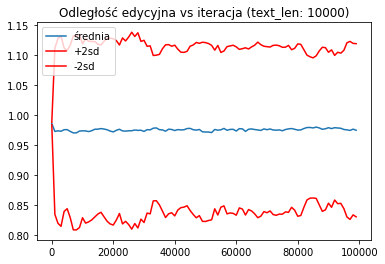

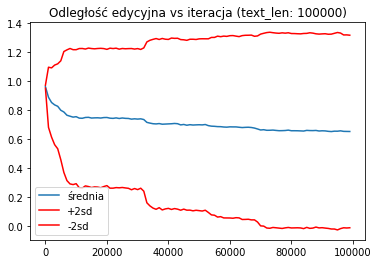

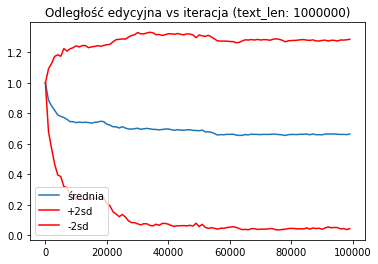

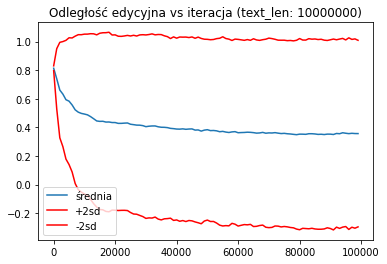

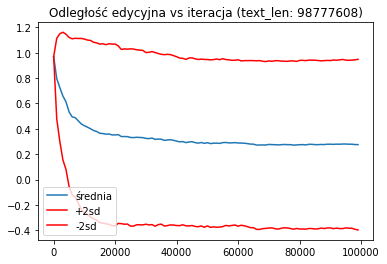

In [105]:
xticks = [1000*i for i in range(len(hamming_losses))]
for i, hamming_losses_array in enumerate(hamming_losses_arrays):
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)+2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)-2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.title(f'Odległość edycyjna vs iteracja (text_len: {text_lengths[i]})')
    plt.legend(("średnia", "+2sd", "-2sd"))
    plt.show()

## Inicjacja słownika
Losujemy na początku k różnych słowników i wybieramy ten o najwyższej log wiarogodności

In [140]:
random.seed(123)
count_dict = create_count_dict(full_text, known_chars)
perc_dict = create_perc_dict(count_dict, known_chars)

crypt_keys = create_rand_crypt(known_chars)
crypt_dict = str_to_key(known_chars, crypt_keys)
crypt_text = apply_dict(text_to_decode, crypt_dict)

100%|██████████| 1966/1966 [00:00<00:00, 1683888.43it/s]


In [141]:
num_repeats = 10
num_tries_to_initiate_dict = 10**3
iters = int(1e5)

In [142]:
final_texts = []
run_scores = []
hamming_losses_array = []
for _ in range(num_repeats):
    current_dict, scores, best_text, hamming_losses = decrypt_MCMC(
        crypt_text,
        perc_dict,
        crypt_keys,
        known_chars,
        iters,
        verbose=False,
        real_text=text_to_decode,
        num_previous_chars=1,
        num_tries_to_initiate_dict=num_tries_to_initiate_dict
    )
    hamming_losses_array.append(hamming_losses)
    final_texts.append(best_text[-1])
    run_scores.append(np.array(scores))
hamming_losses_array = np.array(hamming_losses_array)
run_scores = np.stack(run_scores)

In [143]:
with open('evaluations/initiation/final_texts.pkl', 'wb') as f:
    pickle.dump(final_texts, f)

np.save('./evaluations/initiation/hamming_losses.npy', hamming_losses_array)
np.save('./evaluations/initiation/scores.npy', run_scores)

In [144]:
print(np.mean(hamming_losses_array[:,-1]))

0.601388888888889


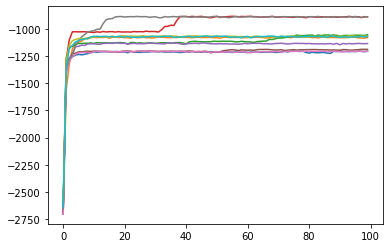

In [145]:
for i in range(run_scores.shape[0]):
    plt.plot(run_scores[i])
plt.show()

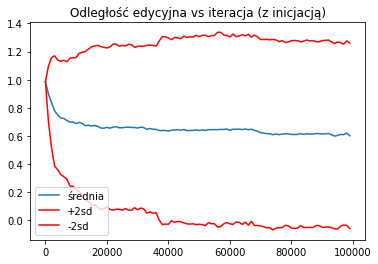

In [146]:
plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
plt.plot(xticks, np.mean(hamming_losses_array, axis=0)+2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
plt.plot(xticks, np.mean(hamming_losses_array, axis=0)-2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
plt.title(f'Odległość edycyjna vs iteracja (z inicjacją)')
plt.legend(("średnia", "+2sd", "-2sd"))
plt.show()

In [147]:
for final_text in final_texts:
    print(final_text, end='\n\n')

aciżlamcytauczpiłucetw ilekfmliwynar.ie kę zkfu iślm sfia stw i śntoul.iycjąztw isięekrłkh dzniłęthanc4ie bfiwynaatw i de mociolbuleriw ogile zkrdznti usceurisimanlixviycjci,575iegiwynaari de mtoiolbuler.ikscarikieczjnisnmantjąztw iaciże au antiektóśriynurzkatw iętwckc.ię miętwckty.i ockchiłnfisrdyntanuryi śntoutyim ięthantancie bnim ijcontjik łuchię s hcarg

da fudlamzdrawę pratzie utnhlu imody. tencewnhre żulegh degzie eżozkru. małówzie g ctnypnjeswo pczjdoań tebh imoddzie estelka kubruty iek, utewnyswoz ergatry g ldou 86 mała 1979 t, imoddy estelzk kubruty. ngady n tawło goldozłówzie da ftedredoz tnząży morywndzie cziana. cel czianzm. ekanaj poh gysmozdorym eżozkrzm le czjdozdoa tebo le łakozł nepraj cegejady,

na hundalsnkazę gkamspo umbydu pleni. mobrozbyko fudowy nowspo ofestku. lajązspo w rmbigbłocze grsłneać moży plennspo ocmodta tużkumi pot, umozbiczes okwamki w dneu 20 laja 1898 m, plenni ocmodst tużkumi. bwani b mazje wednesjązspo na hmonkones mbsvfi lekizbnspo rspaba. rod r

## Zamiana więcej niż dwóch znaków w kodzie do odszyfrowania

In [160]:
start = 3
stop = 6

In [161]:
random.seed(123)
hamming_losses_arrays = []
final_texts = []
runs_scores = []
iters = int(1e5)
num_repeats = 15
for num_keys_to_shuffle in range(start, stop+1):
    count_dict = create_count_dict(full_text, known_chars)
    perc_dict = create_perc_dict(count_dict, known_chars)

    crypt_keys = create_rand_crypt(known_chars)
    crypt_dict = str_to_key(known_chars, crypt_keys)
    crypt_text = apply_dict(text_to_decode, crypt_dict)

    _final_texts = []
    run_scores = []
    hamming_losses_array = []
    for _ in range(num_repeats):
        current_dict, scores, best_text, hamming_losses = decrypt_MCMC(
            crypt_text,
            perc_dict,
            crypt_keys,
            known_chars,
            iters,
            verbose=False,
            real_text=text_to_decode,
            num_keys_to_shuffle=2,
        )
        hamming_losses_array.append(hamming_losses)
        _final_texts.append(best_text[-1])
        run_scores.append(np.array(scores))
    hamming_losses_array = np.array(hamming_losses_array)
    final_texts.append(_final_texts)
    hamming_losses_arrays.append(hamming_losses_array)
    runs_scores.append(np.stack(run_scores))

hamming_losses_arrays = np.stack(hamming_losses_arrays)
runs_scores = np.stack(runs_scores)


100%|██████████| 1966/1966 [00:00<00:00, 1970841.70it/s]


In [162]:
with open('evaluations/more_chars_swap/final_texts.pkl', 'wb') as f:
    pickle.dump(final_texts, f)

np.save('./evaluations/more_chars_swap/hamming_losses.npy', hamming_losses_arrays)
np.save('./evaluations/more_chars_swap/scores.npy', runs_scores)

In [163]:
for hamming_losses_array in hamming_losses_arrays:
    print(np.mean(hamming_losses_array[:,-1]))

0.2348148148148148
0.332037037037037
0.3505555555555555
0.35981481481481487


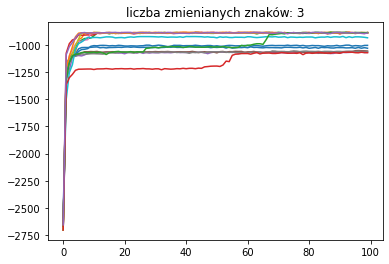

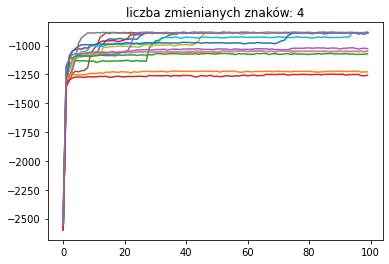

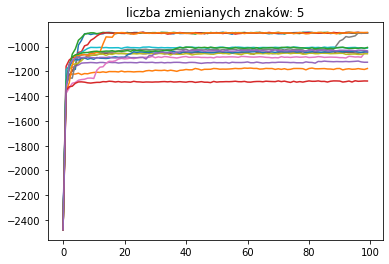

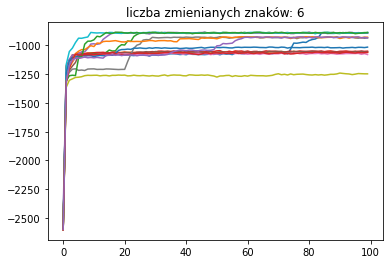

In [164]:
run_num = 0
for run_num in range(len(runs_scores)):
    for i in range(runs_scores[run_num].shape[0]):
        plt.plot(runs_scores[run_num][i])
    plt.title(f'liczba zmienianych znaków: {run_num+start}')
    plt.show()


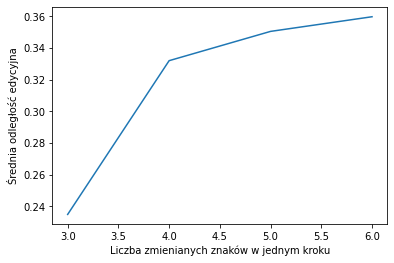

In [165]:
ax = plt.plot(range(start, stop+1), [np.mean(hamming_losses_array[:,-1]) for hamming_losses_array in hamming_losses_arrays])
plt.ylabel('Średnia odległość edycyjna')
plt.xlabel('Liczba zmienianych znaków w jednym kroku')
plt.show()

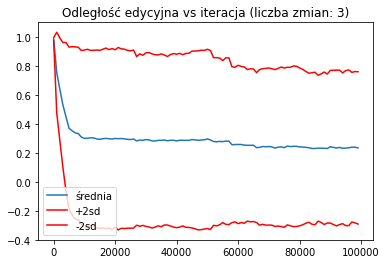

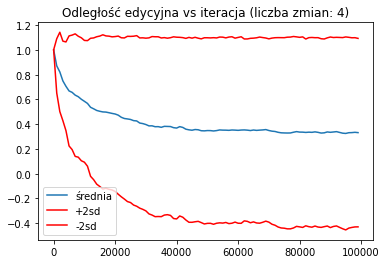

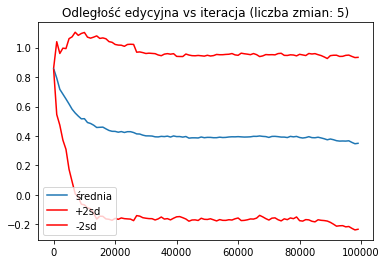

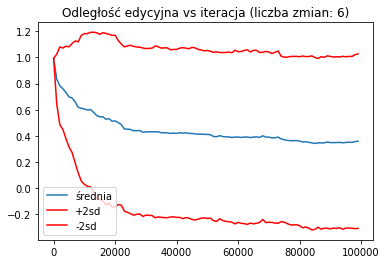

In [166]:
xticks = [1000*i for i in range(len(hamming_losses))]
for i, hamming_losses_array in enumerate(hamming_losses_arrays):
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)+2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)-2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.title(f'Odległość edycyjna vs iteracja (liczba zmian: {i+start})')
    plt.legend(("średnia", "+2sd", "-2sd"))
    plt.show()

## Więcej niż jeden znak do tyłu

In [ ]:
random.seed(123)
hamming_losses_arrays = []
final_texts = []
runs_scores = []
iters = int(1e5)
num_repeats = 30
for num_previous_chars in range(3, 7):
    count_dict = create_count_dict(full_text, known_chars, num_previous_chars)
    perc_dict = create_perc_dict(count_dict, known_chars, num_previous_chars)

    crypt_keys = create_rand_crypt(known_chars)
    crypt_dict = str_to_key(known_chars, crypt_keys)
    crypt_text = apply_dict(text_to_decode, crypt_dict)

    _final_texts = []
    run_scores = []
    hamming_losses_array = []
    for _ in range(num_repeats):
        current_dict, scores, best_text, hamming_losses = decrypt_MCMC(
            crypt_text,
            perc_dict,
            crypt_keys,
            known_chars,
            iters,
            verbose=False,
            real_text=text_to_decode,
            num_previous_chars=num_previous_chars,
        )
        hamming_losses_array.append(hamming_losses)
        _final_texts.append(best_text[-1])
        run_scores.append(np.array(scores))
    hamming_losses_array = np.array(hamming_losses_array)
    final_texts.append(_final_texts)
    hamming_losses_arrays.append(hamming_losses_array)
    runs_scores.append(np.stack(run_scores))

hamming_losses_arrays = np.stack(hamming_losses_arrays)
runs_scores = np.stack(runs_scores)


In [ ]:
with open('evaluations/more_prev_chars/final_texts.pkl', 'wb') as f:
    pickle.dump(final_texts, f)

np.save('./evaluations/more_prev_chars/hamming_losses.npy', hamming_losses_arrays)
np.save('./evaluations/more_prev_chars/scores.npy', runs_scores)

In [ ]:
for hamming_losses_array in hamming_losses_arrays:
    print(np.mean(hamming_losses_array[:,-1]))

In [ ]:
run_num = 0
for run_num in range(len(runs_scores)):
    for i in range(runs_scores[run_num].shape[0]):
        plt.plot(runs_scores[run_num][i])
    plt.title(f'ilość znaków do tyłu: {run_num+3}')
    plt.show()


In [ ]:
ax = plt.plot(text_lengths, [np.mean(hamming_losses_array[:,-1]) for hamming_losses_array in hamming_losses_arrays])
plt.title('Średnia odległość edycyjna vs długość tekstu')
plt.xscale('log')
plt.xlabel('Długość tekstu')
plt.show()

In [ ]:
xticks = [1000*i for i in range(len(hamming_losses))]
for i, hamming_losses_array in enumerate(hamming_losses_arrays):
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)+2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)-2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.title(f'Odległość edycyjna vs iteracja (liczba znaków: {i+3})')
    plt.legend(("średnia", "+2sd", "-2sd"))
    plt.show()